In [42]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
from common_util import setup_axis_default
from matplotlib.lines import Line2D
from scipy.optimize import bisect
from functools import partial   

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR


def jmak_time_to_rx(a1:float,
                    a2: float,
                    B1: float, 
                    B2: float, 
                    n: float,
                    X: float, 
                    T: np.ndarray) -> np.ndarray:

    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0/b*np.log(1./(1. - X))**(1/n) + t_inc  

def gl_to_to_rx(a1:float,
                a2: float,
                B1: float, 
                B2: float, 
                nu: float,
                X: float, 
                T: np.ndarray) -> np.ndarray:

    B = np.exp(a1 + B1/T)
    M = np.exp(a2 + B2/T)
    return M - 1/B*np.log(X**(-nu) - 1)

def get_jmak_rx_temp(a1:float,
                   a2: float,
                   B1: float, 
                   B2: float, 
                   n: float,
                   X: float, 
                   t: np.ndarray,
                   T_range = (800,2000)) -> np.ndarray:

    _func = partial(jmak_time_to_rx, a1,a2,B1,B2,n,X)
    return bisect(lambda temp: _func(temp) -t, *T_range)

def get_gl_rx_temp(a1:float,
                     a2: float,
                     B1: float, 
                     B2: float, 
                     nu: float,
                     X: float, 
                     t: np.ndarray,
                     T_range = (800,2000)) -> np.ndarray:
    
     _func = partial(gl_to_to_rx, a1,a2,B1,B2,nu,X)
     return bisect(lambda temp: _func(temp) -t, *T_range)


JMAK X = 0.1: 1086
JMAK X = 0.9: 1112
Generalized Logistic X = 0.1: 1091
Generalized Logistic X = 0.9: 1116
JMAK X = 0.1: 936
JMAK X = 0.9: 937
Generalized Logistic X = 0.1: 899
Generalized Logistic X = 0.9: 900


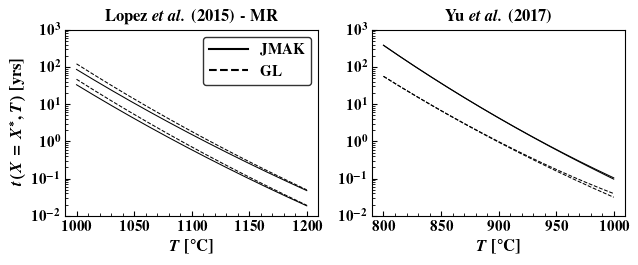

In [53]:
fig,axes = plt.subplots(ncols = 2,figsize = (6.5,2.75))
for ax in axes:
    setup_axis_default(ax)

T_lims = ([1000,1200],[800,1000])
for ax,data_name,Tlim in zip(axes,['Lopez et al. (2015) - MR','Yu et al. (2017)'],T_lims):
    ax.set_xlabel(r'$T$ \textbf{[$^{\circ}$C]}',fontsize = 12)
    ax.set_ylabel(r'$t(X = X^*,T)$ \textbf{[yrs]}',fontsize = 12)
    ax.set_title(r'\textbf{' + data_name.replace('et al.',r'\textit{et al.}') + '}',fontsize = 12)

    temperature = np.linspace(*Tlim,1000) + 273.15
    for ttrx,rx_temp,model_name,ep_param,style in zip([jmak_time_to_rx,gl_to_to_rx],
                                                    [get_jmak_rx_temp,get_gl_rx_temp],
                                                    ['JMAK_{}','Generalized Logistic_{}'],
                                                    ['n','nu'],['-','--']):
        inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_params.csv'),index_col = 0)
        for X in [0.1,0.9]:
            time = ttrx(*inf_summary.loc[['a1','a2','B1','B2',ep_param],'ml'].to_numpy(),X,temperature)
            ax.plot(temperature-273.15,time/SECONDS_TO_YEAR,color = 'k',
                    lw = 0.75,ls = style)
        
            temp = rx_temp(*inf_summary.loc[['a1','a2','B1','B2',ep_param],'ml'].to_numpy(),X,SECONDS_TO_YEAR)
            print(model_name.format('')[:-1] + f' X = {X}:',round(float(temp) - 273.13))
    
    ax.set_yscale('log')
    ax.set_ylim([1e-2,1e3])
    ax.set_yticks(np.logspace(-2,3,6))

legend = axes[0].legend(loc = 'upper right',fontsize = 11,
                   handles = [Line2D([0], [0], color='k', lw=1.5, label=r'\textbf{JMAK}'),
                              Line2D([0], [0], color='k', lw=1.5, ls='--', label=r'\textbf{GL}')],
                   handlelength = 2.5)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)


axes[1].set_ylabel('')
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('rx_temp_example.svg'),bbox_inches = 'tight')
